In [ ]:
## ......  BRAIN TUMOR CLASSIFICATION ...... ##

In [6]:
import numpy as np
import os 
import keras
import pandas as pd 
import matplotlib.pyplot as plt 
import pathlib
from PIL import ImageFilter, ImageOps, Image
import cv2
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score, f1_score, confusion_matrix,precision_recall_fscore_support,roc_curve, auc

In [7]:
path = 'C:\\Users\\Abhijith_Kumble\\Desktop\\IEEE\\brain_Tumor_final\\brain_tumor'
no_of_mri_of_glioma = len(os.listdir(path + '\\Training\\glioma')) + len(os.listdir(path + '\\Testing\\glioma'))
no_of_mri_of_notumor = len(os.listdir(path + '\\Training\\notumor')) + len(os.listdir(path + '\\Testing\\notumor'))
no_of_mri_of_meningioma = len(os.listdir(path + '\\Training\\meningioma')) + len(os.listdir(path + '\\Testing\\meningioma'))
no_of_mri_of_pituitary = len(os.listdir(path + '\\Training\\pituitary'))  + len(os.listdir(path + '\\Testing\\pituitary'))


In [8]:
class_names = [ "glioma" , "meningioma" ,  "pituitary", "notumor"]
no_of_images_in_each_category = [no_of_mri_of_glioma, no_of_mri_of_meningioma, no_of_mri_of_pituitary, no_of_mri_of_notumor]


In [9]:
print(class_names, no_of_images_in_each_category)

['glioma', 'meningioma', 'pituitary', 'notumor'] [1621, 1645, 1757, 2000]


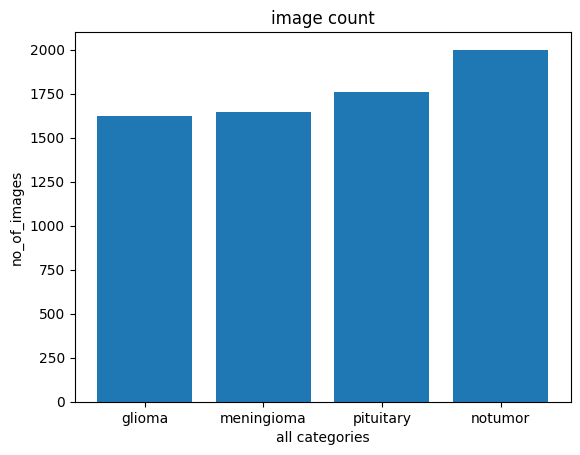

In [11]:
plt.bar(class_names, no_of_images_in_each_category)

plt.xlabel('all categories')
plt.ylabel('no_of_images')
plt.title("image count")

plt.show()

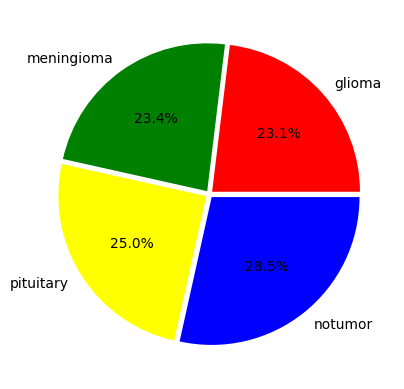

In [16]:
plt.pie(no_of_images_in_each_category, labels=class_names,colors=['red', 'green', 'yellow','blue'], autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025,));

In [13]:
##Data Preprocessing 

In [10]:
X_train = []
Y_train = []
image_size = 112
labels = ['glioma','meningioma','notumor','pituitary']
for i in labels:
    folderPath = os.path.join(path+'\\Training',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        filtered_img= cv2.GaussianBlur(gray, (5,5), cv2.BORDER_DEFAULT)
        equalized_img = cv2.equalizeHist(filtered_img)
        X_train.append(equalized_img)
        Y_train.append(i)

for i in labels:
    folderPath = os.path.join(path+'\\Testing',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        filtered_img= cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT)
        equalized_img = cv2.equalizeHist(filtered_img)
        X_train.append(gray)
        Y_train.append(i)
        
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [11]:
Y_train[Y_train=='glioma']=0
Y_train[Y_train=='meningioma']=1
Y_train[Y_train=='notumor']=2
Y_train[Y_train=='pituitary']=3

In [12]:
Y_train = to_categorical(Y_train,num_classes=4)

In [13]:
print(X_train.shape, Y_train.shape)

(7023, 112, 112) (7023, 4)


In [14]:
np.save('X.npy',X_train)
np.save('Y.npy',Y_train)

In [15]:
X_train = np.load('X.npy')
Y_train = np.load('Y.npy')

In [16]:
Y_train[0]

array([1., 0., 0., 0.], dtype=float32)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.163, random_state=42)
x_train, x_val , y_train, y_val  = train_test_split(X_train, Y_train, test_size=0.1995, random_state=42)

In [28]:
pixel_values = []
for gray_image in X_train:
    pixel_values.extend(gray_image.ravel())

In [18]:
import random

In [19]:
random.seed(42)

In [ ]:
'''fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 5),)
    
axes[0]=(cv2.cvtColor(cv2.imread(os.listdir(path+'\\Training'+'\\notumor')[524%no_of_mri_of_notumor]),cv2.COLOR_BGR2RGB))
plt.show()

'''

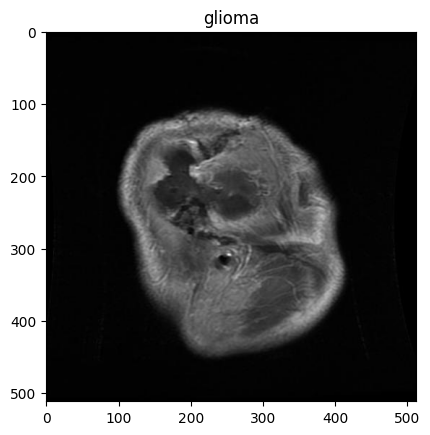

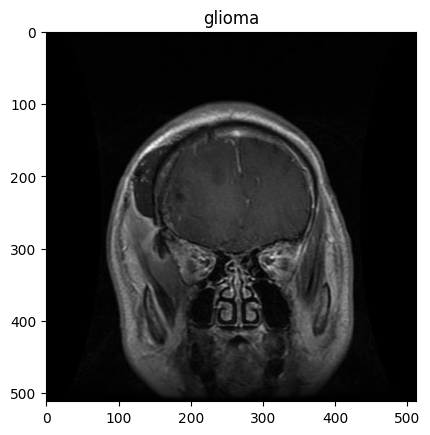

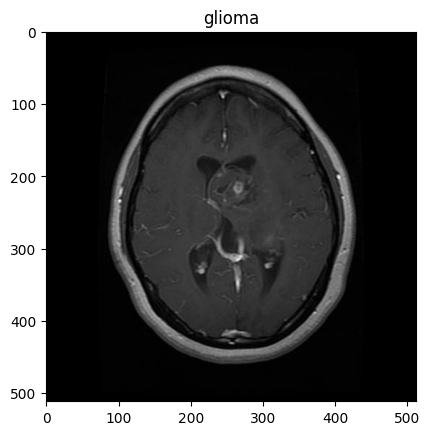

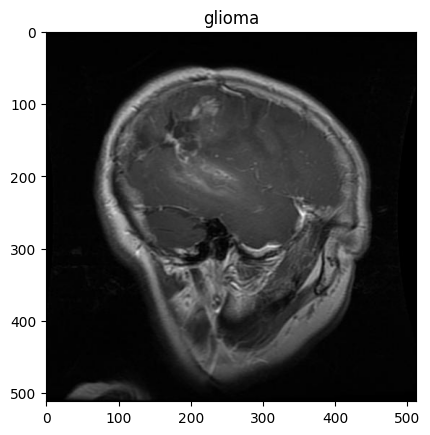

In [20]:
for i in range(4):
    k=random.randint(0,3000)
    img = cv2.imread(os.path.join(path+'\\Training'+'\\glioma', os.listdir(path+'\\Training'+'\\glioma')[k%no_of_mri_of_glioma]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.imshow(img)
    plt.title('glioma')
    plt.show()
    img = cv2.imread(os.listdir(path+'\\Training'+'\\notumor')[k%no_of_mri_of_notumor])
    img = cv2.imread(os.listdir(path+'\\Training'+'\\meningioma')[k%no_of_mri_of_meningioma])
    img = cv2.imread(os.listdir(path+'\\Training'+'\\pituitary')[k%no_of_mri_of_pituitary])


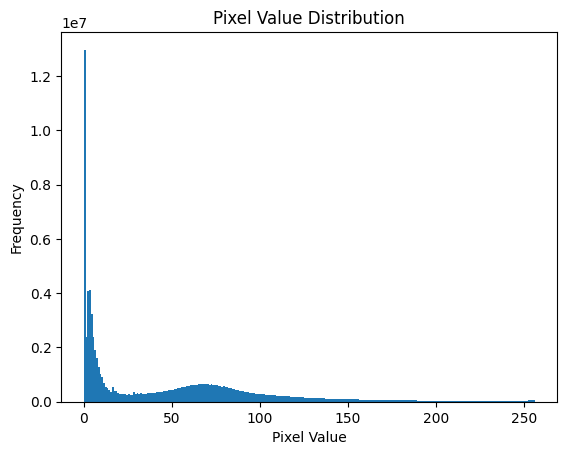

In [23]:
# histogram of the pixel values of the resized image 

plt.hist(pixel_values, bins=256, range=(0, 256))
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
            ## .... CNN MODEL .... ##

In [21]:
model = Sequential([
    
    layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), padding="valid", activation="relu", input_shape=(112,112,1)),
    layers.MaxPooling2D(pool_size=(2,2),strides=(1,1)),
    layers.Dropout(rate=0.25),
    layers.Conv2D(filters=64, kernel_size=(5,5), padding="valid", strides=(1,1), activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2),strides=(1,1)),
    layers.Dropout(rate=.25),
    layers.Conv2D(filters=128,kernel_size=(5,5),strides=(1,1),activation="relu"),
    layers.Dropout(rate=0.4),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(rate=0.3),
    layers.Dense(4, activation="softmax"),
    

])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 108, 108, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 107, 107, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 107, 107, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 103, 103, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 102, 102, 64)     0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 102, 102, 64)      0

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [24]:
model.fit(x= (x_train/255), y= y_train, epochs=10, batch_size=32)


Epoch 1/10
176/176 [==============================] - 663s 4s/step - loss: 1.7721 - accuracy: 0.3572
Epoch 2/10
176/176 [==============================] - 654s 4s/step - loss: 0.6479 - accuracy: 0.7673
Epoch 3/10
176/176 [==============================] - 680s 4s/step - loss: 0.3880 - accuracy: 0.8589
Epoch 4/10
176/176 [==============================] - 676s 4s/step - loss: 0.2711 - accuracy: 0.8981
Epoch 5/10
176/176 [==============================] - 653s 4s/step - loss: 0.2007 - accuracy: 0.9271
Epoch 6/10
176/176 [==============================] - 661s 4s/step - loss: 0.1464 - accuracy: 0.9484
Epoch 7/10
176/176 [==============================] - 661s 4s/step - loss: 0.1223 - accuracy: 0.9550
Epoch 8/10
176/176 [==============================] - 679s 4s/step - loss: 0.1137 - accuracy: 0.9577
Epoch 9/10
176/176 [==============================] - 669s 4s/step - loss: 0.0797 - accuracy: 0.9717
Epoch 10/10
176/176 [==============================] - 662s 4s/step - loss: 0.0795 - accura

In [25]:
model.save('cnn_model2.h5')

In [26]:
from keras.models import load_model

In [27]:
model = load_model('cnn_model2.h5')

In [28]:
# Predict on test data
y_pred = model.predict(x_test/255)
np.save('y_pred_cnn.npy', y_pred)
# Evaluate the model
score = model.evaluate(x_test/255, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

36/36 [==============================] - 22s 599ms/step - loss: 0.3078 - accuracy: 0.9135
Test loss: 0.30777567625045776
Test accuracy: 0.9135371446609497


In [29]:
from sklearn.metrics import classification_report

In [ ]:
## .... PERFORMANCE EVALUATION ....  ##

In [30]:
precision, recall, f1score, _ = precision_recall_fscore_support(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')
Confusion_matrix =confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

print('TEST LOSS: ', round(score[0],4))
print(f'\nTEST ACCURACY : ' ,round(score[1]*100,2),'%')
print('\nPRECISION : ', round(precision,4))
print('\nRECALL : ', round(recall,4))
print('\nF1 SCORE : ', round(f1score,4))
print('\nCONFUSION MATRIX : \n', Confusion_matrix)


TEST LOSS:  0.3078

TEST ACCURACY :  91.35 %

PRECISION :  0.9162

RECALL :  0.9135

F1 SCORE :  0.9138

CONFUSION MATRIX : 
 [[233  39   2   2]
 [ 10 234  15   9]
 [  0   9 315   1]
 [  2   7   3 264]]


In [ ]:
''' 
'glioma'   =    0
'meningioma' =  1
'notumor'   =   2
'pituitary' =   3

'''

In [ ]:
## ROC Curve 

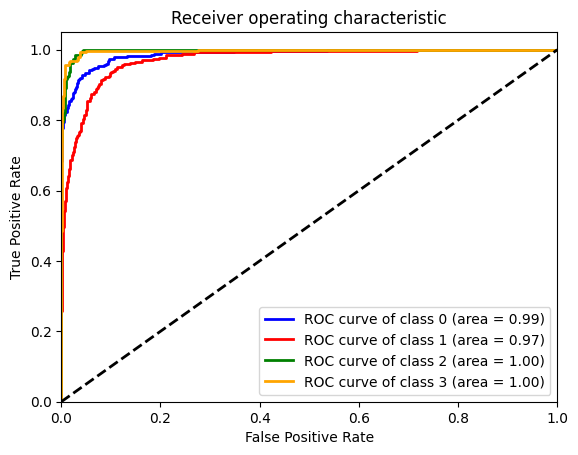

In [31]:
# ROC(Receiver Operating Characteristic) curve for each class
fpr = dict()  ##false positive rate
tpr = dict()  ##true positive rate
roc_auc = dict() ## 

num_classes = 4

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure()
lw = 2
colors = ['blue', 'red', 'green', 'orange'] # you can choose your own colors
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
''' plt.plot(historys['loss'])
plt.plot(historys['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show() '''